# Melodic Expectation with Markov Models

In this notebook we will look at Markov Chains for modelling musical expectation.
We have already seen a Markov Model in the class on key estimation with HMMs (Hidden Markov Models).

In [2]:
import os
import numpy as np
import partitura

In [3]:
from rnn import load_data

# To filter out short melodies The minimum number of notes that a sequence should have

min_seq_len = 10
sequences = load_data(min_seq_len)

## Tasks 1; data loading & preparing:
1. check out the content of the variable "sequences", if unclear have a look at the loading function.
2. which musical texture do these sequences exhibit? (https://en.wikipedia.org/wiki/Texture_(music))
3. write a function to derive sequences of pitches from this data.
4. write a function to derive sequences of durations from this data. Modify this to compute inter onset intervals (IOIs; the time between two consecutive onsets). Can you encode rests as well by comparing duration with IOI? 

In [4]:
s = list()
for l in sequences:
    s+=list(l["pitch"]%12)

## Tasks 2; data exploration:

1. compute and draw a histogram of pitches. Modify this to show pitch classes!
2. compute and draw a histogram of IOIs. The input MIDI files are deadpan, i.e. the IOIs in seconds correspond to the notated duration exactly. Look through the IOIs and make an educated guess for some smallest float time unit that could serve as integer smallest time division. Encode the IOIs as multiples of this smallest integer. Which multiples make musical sense?

50985


(array([4108., 4335., 4232., 4357., 4314., 4123., 4378., 4177., 4404.,
        4047., 4184., 4326.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 12 artists>)

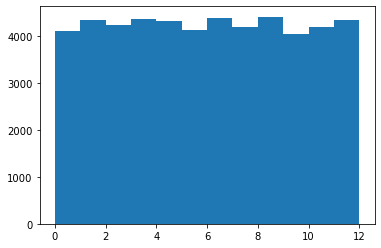

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
print(len(s))
plt.hist(s, bins=12, range=(0,12))

## Tasks 3; A Markov Chain:

1. choose a data type to model: pitch, pitch class, IOIs, or durations (including or without an encoding for rests). Concatenate all the sequences into one long data sequence.

2. You have now a sequence **X** of symbols from an alphabet **A** (set of possible symbols of your chosen data type):

$$ \mathbf{X} = \{\mathbf{x_0}, \dots, \mathbf{x_n} \mid \mathbf{x}_{i} \in  \mathbf{A} \forall i \in 0, \dots, n \}$$

Compute the empirical conditional probability of seeing any symbol after just having seen any other:

$$ \mathbb{P}(\mathbf{x_i}\mid \mathbf{x_{i-1}}) $$

What is the dimensionality of this probability  given $\lvert A \rvert = d $? Do you recall what this probability was called in the context of HMMs?

3. compute the entropy of the data (only your chosen type). Recall https://en.wikipedia.org/wiki/Entropy_(information_theory)


[4108. 4335. 4232. 4357. 4314. 4123. 4378. 4177. 4404. 4047. 4184. 4325.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


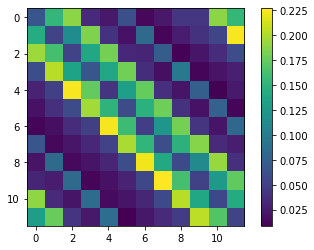

In [6]:
probs = np.zeros((12,12))
for (p1, p2) in zip(s[:-1],s[1:]):
    probs[p1, p2] += 1

probsum = np.sum(probs, axis = 1)
print(probsum)
normalized_distribution = (probs.T/probsum).T
plt.imshow(normalized_distribution)
plt.colorbar()
print(np.sum(normalized_distribution, axis = 1))

## Tasks 4; Markov Chain Generation:

1. By computing the probability $ \mathbb{P}(\mathbf{x_i}\mid \mathbf{x_{i-1}}) $ in task 3 you have fully specified a discrete-time finite state space Markov Chain model (https://en.wikipedia.org/wiki/Discrete-time_Markov_chain)! Given an initial symbol "s_0", you can generate the subsequent symbols by sampling from the conditional probability distribution

$$ \mathbb{P}(\mathbf{x_i}\mid \mathbf{x_{i-1}} = \mathbf{s_{0}}) $$

Write a function that samples from a finite state space given an input probability distribution.

2. Use the previously defined function and the Markov Chain to write a sequence generator based on an initial symbol.
3. Start several "walkers", i.e. sampled/generated sequences. Compute the entropy of this generated data and compare it to the entropy in task 3.


In [7]:
def sample(distribution):
    cs = distribution.cumsum()
    samp = np.random.rand(1)
    return list(samp < cs).index(True)
    

def generate(start = 0, length = 100):
    melody = [start]
    for k in range(length):
        melody.append(sample(normalized_distribution[melody[-1],:]))
    return melody

print(generate())

[0, 11, 10, 9, 2, 11, 10, 1, 3, 1, 11, 2, 7, 8, 7, 8, 6, 4, 6, 11, 10, 8, 0, 4, 6, 1, 11, 0, 11, 1, 11, 1, 9, 7, 3, 5, 3, 0, 2, 11, 1, 3, 8, 6, 2, 4, 6, 11, 11, 9, 9, 3, 4, 2, 1, 3, 4, 8, 10, 7, 0, 5, 3, 5, 2, 0, 5, 7, 0, 9, 8, 5, 3, 1, 1, 11, 10, 8, 9, 11, 9, 8, 2, 4, 10, 0, 1, 10, 10, 11, 0, 2, 4, 3, 7, 8, 6, 5, 3, 11, 1]


## Tasks 5; n-gram Context Model:

1. The Markov Chains used until now have only very limited memory. In fact, they only ever know the last played pitch or duration. Longer memory models can be created by using the conditional probability of any new symbol based on an n-gram context of the symbol (https://en.wikipedia.org/wiki/N-gram):
$$ \mathbb{P}(\mathbf{x_i}\mid \mathbf{x_{i-1}}, \dots, \mathbf{x_{i-n}}) $$

This probability will generally not look like a matrix anymore, but we can easily encode it as a dictionary. Write a function that creates a 3-gram context model from the data sequence **X**!

2. The longer the context, the more data we need to get meaningful or even existing samples for all contexts (note that the number of different contexts grows exponentially with context length). What could we do to approximate the distribution for unseen contexts?

In [12]:
from collections import defaultdict
import copy

def create_context_model(sequence, n):
    a_priori_probability = np.array([1,1,1,1,1,1,1,1,1,1,1,1])/12
    context_model = defaultdict(lambda: copy.copy(a_priori_probability))
    for idx in range(len(sequence)-n):
        local_string = ""
        for p in sequence[idx:idx+n]:
            local_string += str(p)
        context_model[local_string][sequence[idx+n]] += 1
    
    for key in context_model.keys():
        prob_dist = context_model[key]
        context_model[key] =  prob_dist/ prob_dist.sum()     
    
    return context_model
            
cm = create_context_model(s, 5)

In [13]:
def generate_with_context_model(start = [0,0,0], length = 100, context_model= cm):
    melody = start
    for k in range(length):
        key = ""
        for p in melody[-3:]:
            key += str(p)
        melody.append(sample(context_model[key]))
    return melody

print(generate_with_context_model())

[0, 0, 0, 3, 6, 10, 8, 1, 11, 1, 4, 6, 7, 1, 2, 8, 5, 8, 2, 2, 5, 3, 4, 10, 11, 4, 5, 8, 6, 11, 2, 0, 3, 10, 9, 5, 8, 8, 10, 2, 7, 5, 8, 4, 8, 3, 4, 6, 0, 0, 0, 2, 8, 2, 6, 8, 10, 9, 4, 9, 10, 11, 10, 5, 7, 11, 2, 1, 2, 3, 6, 5, 9, 11, 7, 8, 0, 7, 5, 4, 0, 10, 4, 7, 5, 1, 8, 10, 3, 7, 8, 11, 4, 6, 10, 0, 11, 6, 1, 11, 11, 1, 1]


## Tasks 6; multi-type Markov Chains and back to music:

1. To generate a somewhat interesting melody, we want to get a sequence of both pitches and durations. If we encode rests too, we can generate any melody like this. So far our Markov Chains dealt with either pitch or duration/IOI. What could we do to combine them? Describe two approaches and why to choose which one.

2. Implement a simple melody generator with pitch and IOI/duration (simplest; modify taska 4; 2 to a generator of the other type and use them to create independent seuqnces). Write some generated melodies to MIDI files!

## (Tasks 7); more stuff for music:

1. Keys are perceptual centers of gravity in the pitch space, so if we transpose all the input sequences to the same key we can compute empirical pitch distributions within a key!

2. One solution to tasks 5, 2 is to use Prediction by Partial Matching. This is the basis of the most elaborate probabilitstic model ofsymbolic music the Information Dynamics of Music (IDyOM). See references here:
https://researchcommons.waikato.ac.nz/bitstream/handle/10289/9913/uow-cs-wp-1993-12.pdf
https://mtpearce.github.io/idyom/
